In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import time
import matplotlib.pyplot as plt

In [2]:

# For reading both the datasets
file = "trips_by_distance.csv.csv"
file2 =  "trips_full_data__2_.csv"


# To convert the datatypes of required columns of large dataset
dtypes = {
    "County Name": "object",
    "State Postal Code": "object",
    "Level": "object",
    "Date": "object",
    "State FIPS": "object",
    "County FIPS": "float64",
    "Population Staying at Home": "float64",
    "Population Not Staying at Home": "float64",
    "Number of Trips": "float64",
    "Number of Trips <1": "float64",
    "Number of Trips 1-3": "float64",
    "Number of Trips 3-5": "float64",
    "Number of Trips 5-10": "float64",
    "Number of Trips 10-25": "float64",
    "Number of Trips 25-50": "float64",
    "Number of Trips 50-100": "float64",
    "Number of Trips 100-250": "float64",
    "Number of Trips 250-500": "float64",
    "Number of Trips >=500": "float64"
}

# Since trips_by_distance is a large dataset with almost 100000 values, dask is best to handle it.
df1 = dd.read_csv(file, dtype = dtypes, blocksize=None)
df2 = dd.read_csv(file2)


print("First large dataset is loaded successfully after conversions!")
print(df1.dtypes)


First large dataset is loaded successfully after conversions!
Level                              object
Date                               object
State FIPS                         object
State Postal Code                  object
County FIPS                       float64
County Name                        object
Population Staying at Home        float64
Population Not Staying at Home    float64
Number of Trips                   float64
Number of Trips <1                float64
Number of Trips 1-3               float64
Number of Trips 3-5               float64
Number of Trips 5-10              float64
Number of Trips 10-25             float64
Number of Trips 25-50             float64
Number of Trips 50-100            float64
Number of Trips 100-250           float64
Number of Trips 250-500           float64
Number of Trips >=500             float64
Row ID                             object
Week                                int64
Month                               int64
dtype: object


In [3]:
print(df1.isna().sum().compute())
print(" ")
print(df2.isna().sum().compute())
print(" ")
print("First dataset:", df1.info())
print(" ")
print("Second Dataset:",df2.info())

Level                                 0
Date                                  0
State FIPS                          901
State Postal Code                   901
County FIPS                       46852
County Name                       46852
Population Staying at Home        12950
Population Not Staying at Home    12950
Number of Trips                   12950
Number of Trips <1                12950
Number of Trips 1-3               12950
Number of Trips 3-5               12950
Number of Trips 5-10              12950
Number of Trips 10-25             12950
Number of Trips 25-50             12950
Number of Trips 50-100            12950
Number of Trips 100-250           12950
Number of Trips 250-500           12950
Number of Trips >=500             12950
Row ID                                0
Week                                  0
Month                                 0
dtype: int64
 
Month of Date                 0
Week of Date                  0
Year of Date                  0
Level    

In [4]:
# Since only the large dataset has null values use fillna() for df1 and drop duplicates.
df1 = df1.fillna(0)
df1 = df1.drop_duplicates()

#Again check for nullvalues
print(df1.isna().sum().compute())

Level                             0
Date                              0
State FIPS                        0
State Postal Code                 0
County FIPS                       0
County Name                       0
Population Staying at Home        0
Population Not Staying at Home    0
Number of Trips                   0
Number of Trips <1                0
Number of Trips 1-3               0
Number of Trips 3-5               0
Number of Trips 5-10              0
Number of Trips 10-25             0
Number of Trips 25-50             0
Number of Trips 50-100            0
Number of Trips 100-250           0
Number of Trips 250-500           0
Number of Trips >=500             0
Row ID                            0
Week                              0
Month                             0
dtype: int64


In [5]:
# Since date is an important part, converting the dates in both th edatasets to the uniform datetime format
df1['Date'] = dd.to_datetime(df1['Date'])  
df2['Date'] = dd.to_datetime(df2['Date'])

# With this data cleaning steps are finished.

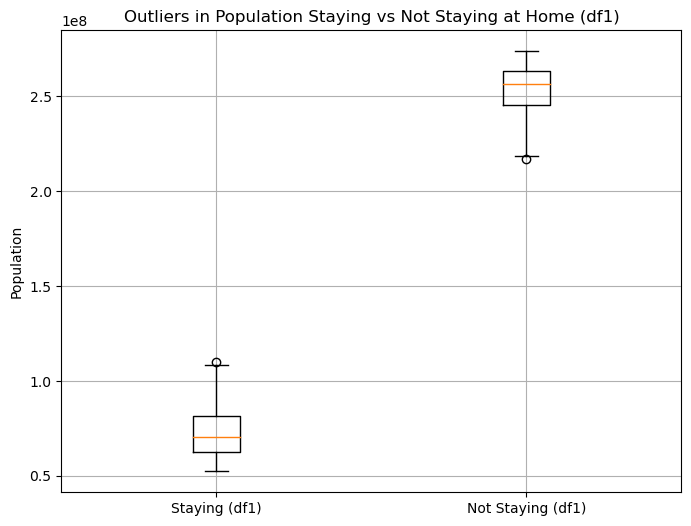

In [6]:
#Just a box plot visualizationbaseed on the national level data in both the datasets

import matplotlib.pyplot as plt

# Convert Dask DataFrames to pandas
df1_pd = df1.compute()
df2_pd = df2.compute()
# Convert Dask DataFrames to pandas
df1_national = df1_pd[df1_pd['Level'] == 'National']
df2_national = df2_pd[df2_pd['Level'] == 'National']

# First dataset outlier graph based on National level
plt.figure(figsize=(8, 6))
plt.boxplot([
    df1_national['Population Staying at Home'].dropna(),
    df1_national['Population Not Staying at Home'].dropna()
], labels=['Staying (df1)', 'Not Staying (df1)'])
plt.title('Outliers in Population Staying vs Not Staying at Home (df1)')
plt.ylabel('Population')
plt.grid(True)
plt.show()


# Second dataset outlier graph based on National level
plt.figure(figsize=(8, 6))
plt.boxplot([
    df2_national['Population Staying at Home'].dropna(),
    df2_national['People Not Staying at Home'].dropna()
], labels=['Staying (df2)', 'Not Staying (df2)'])
plt.title('Outliers in Population Staying vs Not Staying at Home (df2)')
plt.ylabel('Population')
plt.grid(True)
plt.show()



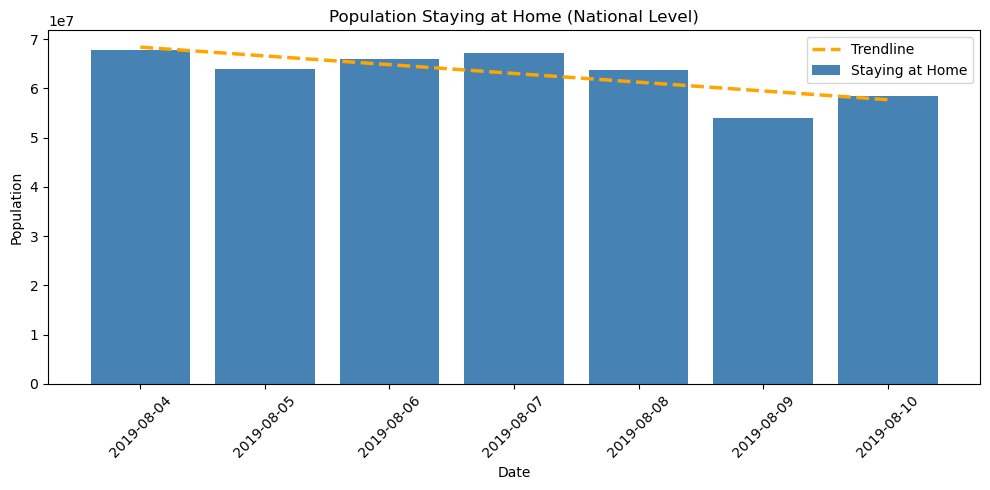

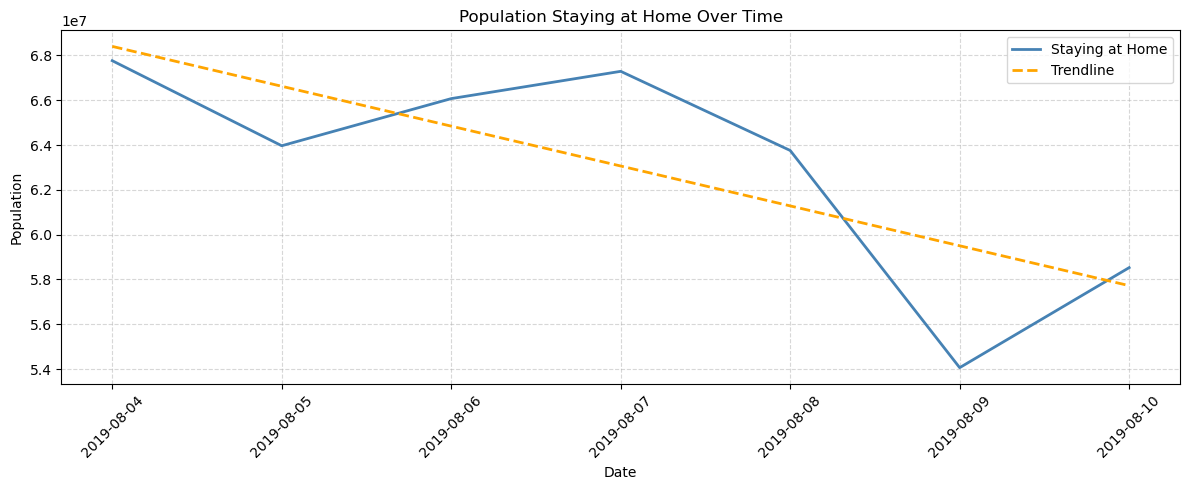

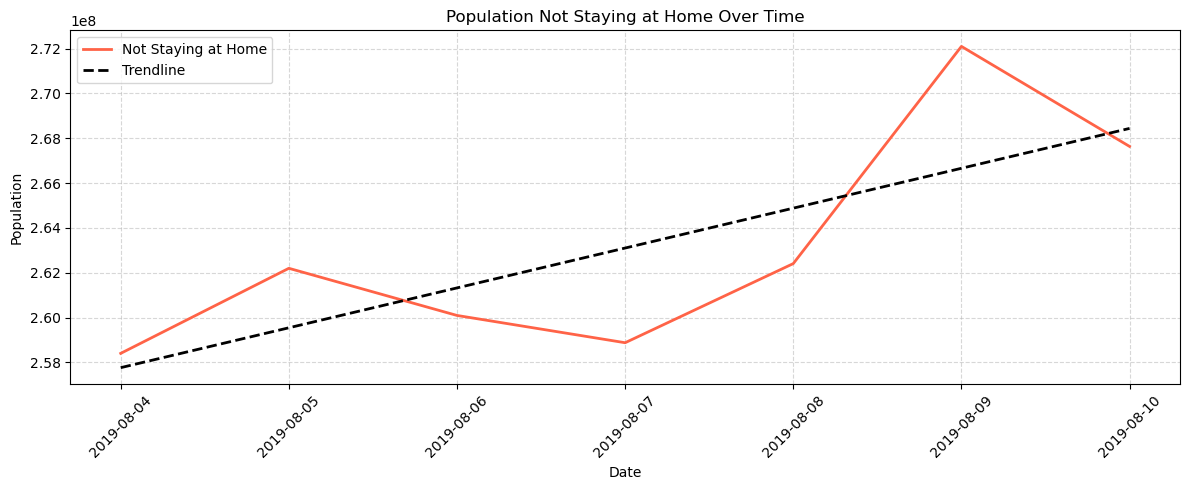

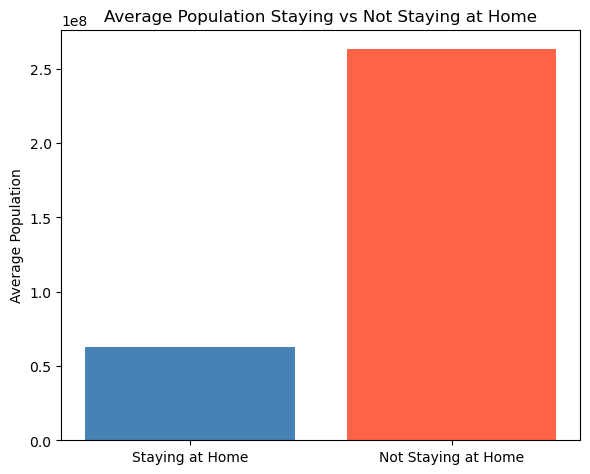

In [7]:
##Question 1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Filter only national-level data from first large dataset
national_level = df1[df1['Level'] == "National"]

# 2. Drop unnecessary columns from first large dataset
national_level = national_level.drop(columns=[
    'State FIPS', 'State Postal Code', 'County FIPS', 'County Name'
], errors='ignore')

# Remove extra spaces from second dataset
df2.columns = df2.columns.str.strip()  

#Drop unnecessary columns in second small dataset
df2 = df2.drop(columns=[
    "Month of Date", "Week of Date", "Year of Date", "Level",
    "Trips", "Week Ending Date"
], errors='ignore')

# 3. Filter both datasets to matching date ranges
national_level = national_level[
    national_level["Date"].between(df2['Date'].min(), df2['Date'].max())
].compute()

df2 = df2[
    df2["Date"].between(national_level['Date'].min(), national_level['Date'].max())
]

df2=df2.compute()

# 4. Group national data by date (only numeric columns) to find the mean 
numeric_national = national_level.select_dtypes(include='number')
grouped_national = national_level.groupby('Date')[numeric_national.columns].mean()

numeric_df2 = df2.select_dtypes(include='number')
grouped_small = df2.groupby('Date')[numeric_df2.columns].mean()


# 5. Plot: Population Staying at Home + Trendline
plt.figure(figsize=(10, 5))
x = grouped_national.index.map(pd.Timestamp.toordinal)
y = grouped_national['Population Staying at Home']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.bar(grouped_national.index, y, color='steelblue', label='Staying at Home')
plt.plot(grouped_national.index, p(x), color='orange', linewidth=2.5, linestyle='--', label='Trendline')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Population Staying at Home (National Level)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# 6. Plot: Population Not Staying at Home + Trendline
plt.figure(figsize=(10, 5))
x2 = grouped_small.index.map(pd.Timestamp.toordinal)
y2 = grouped_small['People Not Staying at Home']
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.bar(grouped_small.index, y2, color='tomato', label='Not Staying at Home')
plt.plot(grouped_small.index, p2(x2), color='black', linewidth=2.5,linestyle='--', label='Trendline')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('Population Not Staying at Home (National Level)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

    
    
    # 8. Line Plot: Staying vs Not Staying at Home
# --- Line Chart 1: Population Staying at Home ---
plt.figure(figsize=(12, 5))
dates = grouped_national.index
x_dates = dates.map(pd.Timestamp.toordinal)

# Actual data
plt.plot(dates, grouped_national['Population Staying at Home'],
         label='Staying at Home', color='steelblue', linewidth=2)

# Trendline
z_home = np.polyfit(x_dates, grouped_national['Population Staying at Home'], 1)
p_home = np.poly1d(z_home)
plt.plot(dates, p_home(x_dates), color='orange', linestyle='--', linewidth=2, label='Trendline')

# Formatting
plt.title('Population Staying at Home Over Time')
plt.xlabel('Date')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Line Chart 2: Population Not Staying at Home ---
plt.figure(figsize=(12, 5))
x_dates2 = dates.map(pd.Timestamp.toordinal)  # same dates used here

# Actual data
plt.plot(dates, grouped_small['People Not Staying at Home'],
         label='Not Staying at Home', color='tomato', linewidth=2)

# Trendline
z_not_home = np.polyfit(x_dates2, grouped_small['People Not Staying at Home'], 1)
p_not_home = np.poly1d(z_not_home)
plt.plot(dates, p_not_home(x_dates2), color='black', linestyle='--', linewidth=2, label='Trendline')

# Formatting
plt.title('Population Not Staying at Home Over Time')
plt.xlabel('Date')
plt.ylabel('Population')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


#bar chart: Average population staying at home vs Population not staying at home.
means = {
    'Staying at Home': grouped_national['Population Staying at Home'].mean(),
    'Not Staying at Home': grouped_small['People Not Staying at Home'].mean()
}

plt.figure(figsize=(6, 5))
plt.bar(means.keys(), means.values(), color=['steelblue', 'tomato'])
plt.title('Average Population Staying vs Not Staying at Home')
plt.ylabel('Average Population')
plt.tight_layout()
plt.show()

Your machine has 8 logical cores

 Simulating 10 processors using 10 partitions...


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


Time with 10 processors: 5.6353 seconds

 Simulating 20 processors using 20 partitions...


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


Time with 20 processors: 4.1456 seconds

 Running baseline (Sequential Pandas)...
 Sequential time: 2.2151 seconds


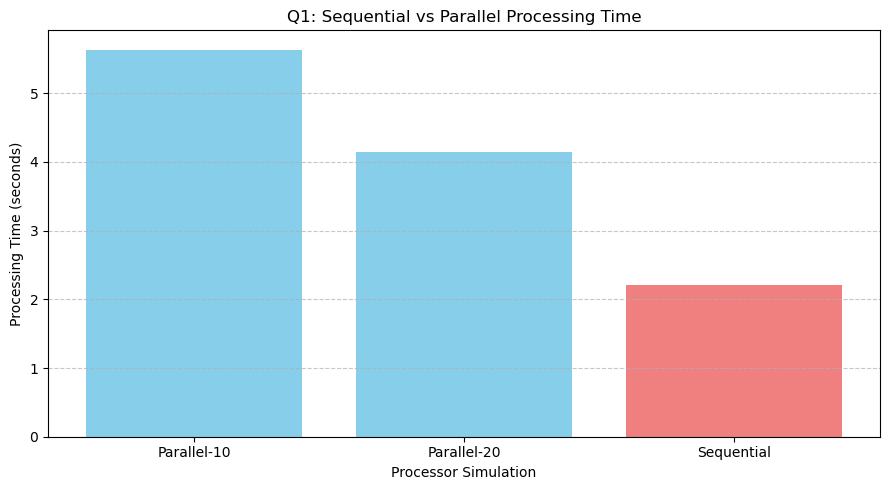


 Summary:
Parallel-10: 5.6353 seconds
Parallel-20: 4.1456 seconds
Sequential: 2.2151 seconds


In [8]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import time
from dask.distributed import Client, LocalCluster
import os

# Load datasets
file1 = "trips_by_distance.csv.csv"
file2 = "trips_full_data__2_.csv"

df1_pandas = pd.read_csv(file1, low_memory=False)
df2_pandas = pd.read_csv(file2, low_memory=False)
df2_pandas['Date'] = pd.to_datetime(df2_pandas['Date'], errors='coerce')

# Check system cores
physical_cores = os.cpu_count()
print(f"Your machine has {physical_cores} logical cores")

# Simulate parallel runs
test_configs = {
    10: 10,
    20: 20,
}

processor_times = {}

# Run for each parallel config
for label, partitions in test_configs.items():
    print(f"\n Simulating {label} processors using {partitions} partitions...")

    cluster = LocalCluster(n_workers=physical_cores, threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    ddf = dd.from_pandas(df1_pandas.copy(), npartitions=partitions)
    ddf['Date'] = dd.to_datetime(ddf['Date'], errors='coerce')

    df2_clean = df2_pandas.drop(columns=[
        "Month of Date", "Week of Date", "Year of Date", "Level",
        "Trips", "Week Ending Date"
    ], errors='ignore')
    df2_clean.columns = df2_clean.columns.str.strip()

    national_level = ddf[ddf['Level'] == "National"]
    national_level = national_level.drop(columns=[
        'State FIPS', 'State Postal Code', 'County FIPS', 'County Name'
    ], errors='ignore')

    national_level = national_level[
        national_level["Date"].between(df2_pandas['Date'].min(), df2_pandas['Date'].max())
    ].compute()

    df2_filtered = df2_clean[
        df2_clean["Date"].between(national_level['Date'].min(), national_level['Date'].max())
    ]

    numeric_national = national_level.select_dtypes(include='number')
    grouped_national = national_level.groupby('Date')[numeric_national.columns].mean()

    numeric_df2 = df2_filtered.select_dtypes(include='number')
    grouped_small = df2_filtered.groupby('Date')[numeric_df2.columns].mean()

    _ = grouped_national['Population Staying at Home'].mean()
    _ = grouped_small['People Not Staying at Home'].mean()

    end = time.time()
    processor_times[f"Parallel-{label}"] = end - start
    print(f"Time with {label} processors: {end - start:.4f} seconds")

    client.close()
    cluster.close()

# Sequential version (Pandas baseline)
print("\n Running baseline (Sequential Pandas)...")

start_serial = time.time()

df1_pandas['Date'] = pd.to_datetime(df1_pandas['Date'], errors='coerce')
df2_pandas['Date'] = pd.to_datetime(df2_pandas['Date'], errors='coerce')

df2_clean = df2_pandas.drop(columns=[
    "Month of Date", "Week of Date", "Year of Date", "Level",
    "Trips", "Week Ending Date"
], errors='ignore')
df2_clean.columns = df2_clean.columns.str.strip()

national_level = df1_pandas[df1_pandas['Level'] == "National"]
national_level = national_level.drop(columns=[
    'State FIPS', 'State Postal Code', 'County FIPS', 'County Name'
], errors='ignore')

national_level = national_level[
    national_level["Date"].between(df2_pandas['Date'].min(), df2_pandas['Date'].max())
]

df2_filtered = df2_clean[
    df2_clean["Date"].between(national_level['Date'].min(), national_level['Date'].max())
]

numeric_national = national_level.select_dtypes(include='number')
grouped_national = national_level.groupby('Date')[numeric_national.columns].mean()

numeric_df2 = df2_filtered.select_dtypes(include='number')
grouped_small = df2_filtered.groupby('Date')[numeric_df2.columns].mean()

_ = grouped_national['Population Staying at Home'].mean()
_ = grouped_small['People Not Staying at Home'].mean()

end_serial = time.time()
processor_times['Sequential'] = end_serial - start_serial
print(f" Sequential time: {end_serial - start_serial:.4f} seconds")

# === Plotting
labels = list(processor_times.keys())
times = list(processor_times.values())
x_pos = list(range(len(labels)))

plt.figure(figsize=(9, 5))
plt.bar(x_pos, times, color=['lightcoral' if l == 'Sequential' else 'skyblue' for l in labels])
plt.xticks(x_pos, labels)
plt.xlabel("Processor Simulation")
plt.ylabel("Processing Time (seconds)")
plt.title("Q1: Sequential vs Parallel Processing Time")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Summary
print("\n Summary:")
for label in labels:
    print(f"{label}: {processor_times[label]:.4f} seconds")


In [9]:
# 8. Summary Interpretation

# --- 1. Mean number of people staying at home ---
mean_staying_home = grouped_national['Population Staying at Home'].mean()
print(f"\n On average, {mean_staying_home:,.0f} people were staying at home per day (national level).")

# --- 2. Mean number of people not staying at home ---
mean_not_staying_home = grouped_small['People Not Staying at Home'].mean()
print(f" On average, {mean_not_staying_home:,.0f} people were NOT staying at home per day (national level).")

# --- 3. How far are people traveling ---
distance_columns = [col for col in df2.columns if 'Trips' in col and ('<' in col or '-' in col or 'Miles' in col)]
if distance_columns:
    trip_means = df2[distance_columns].select_dtypes(include='number').mean()

    plt.figure(figsize=(10, 5))
    x_vals = np.arange(len(trip_means))
    y_vals = trip_means.values
    z3 = np.polyfit(x_vals, y_vals, 1)
    p3 = np.poly1d(z3)
if not trip_means.empty:
    print("\n Average number of trips by distance (when people didn't stay home):")
    for dist, avg in trip_means.items():
        print(f"  - {dist}: {avg:,.0f} trips per day")



 On average, 63,063,370 people were staying at home per day (national level).
 On average, 263,104,050 people were NOT staying at home per day (national level).

 Average number of trips by distance (when people didn't stay home):
  - Trips <1 Mile: 325,976,363 trips per day
  - Trips 1-25 Miles: 1,015,555,465 trips per day
  - Trips 1-3 Miles: 369,476,657 trips per day
  - Trips 10-25 Miles: 231,078,511 trips per day
  - Trips 100-250 Miles: 6,850,130 trips per day
  - Trips 100+ Miles: 12,122,473 trips per day
  - Trips 25-100 Miles: 88,037,455 trips per day
  - Trips 25-50 Miles: 69,159,131 trips per day
  - Trips 250-500 Miles: 1,829,242 trips per day
  - Trips 3-5 Miles: 181,555,834 trips per day
  - Trips 5-10 Miles: 233,444,464 trips per day
  - Trips 50-100 Miles: 18,878,323 trips per day
  - Trips 500+ Miles: 3,443,101 trips per day


<Figure size 1000x500 with 0 Axes>


Total dates with >10M 10-25 trips: 901
Total dates with >10M 50-100 trips: 900
Common dates where both had >10M trips: 900


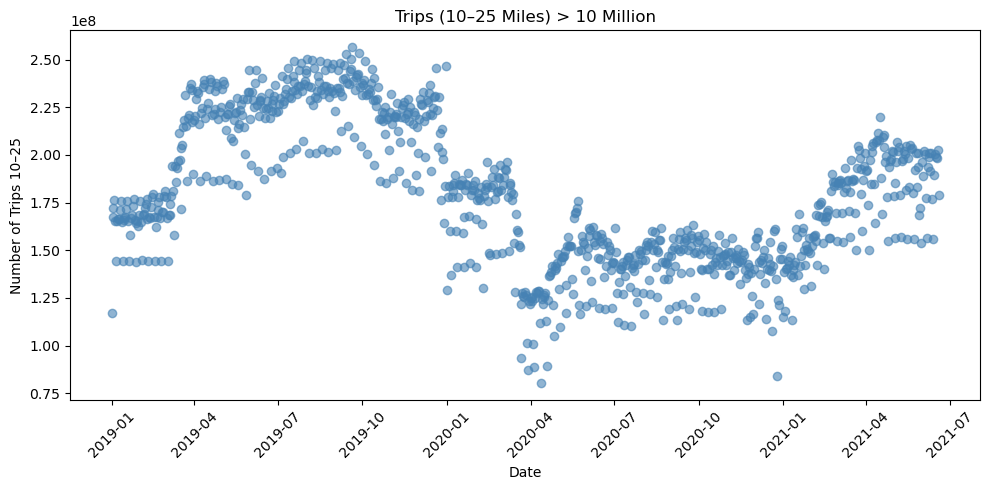

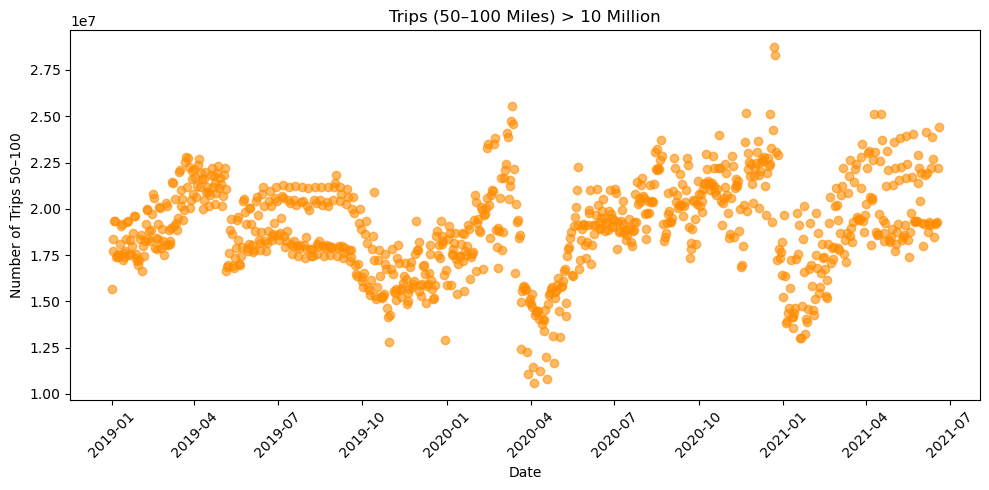

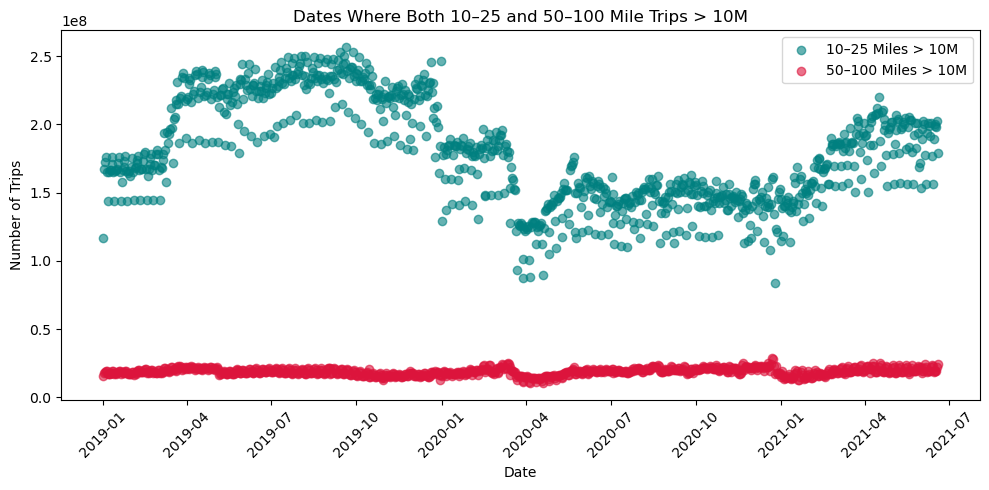

In [10]:
# Question 2

import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd

# Load & filter
national_only = df1[df1['Level'] == "National"]
national_only = national_only[['Date', 'Number of Trips 10-25', 'Number of Trips 50-100']]
national_only['Date'] = dd.to_datetime(national_only['Date'], errors='coerce')

# Filter Dask datasets for > 10 million
set_10_25 = national_only[national_only['Number of Trips 10-25'] > 10_000_000]
set_50_100 = national_only[national_only['Number of Trips 50-100'] > 10_000_000]

# Convert to Pandas
set_10_25_pd = set_10_25.compute()
set_50_100_pd = set_50_100.compute()

# Clean up Date format
set_10_25_pd['Date'] = pd.to_datetime(set_10_25_pd['Date']).dt.date
set_50_100_pd['Date'] = pd.to_datetime(set_50_100_pd['Date']).dt.date

# Create sets of dates
dates_10_25 = set(set_10_25_pd['Date'])
dates_50_100 = set(set_50_100_pd['Date'])

common_dates = dates_10_25 & dates_50_100
only_10_25 = dates_10_25 - dates_50_100
only_50_100 = dates_50_100 - dates_10_25

# Create dataframes for scatter
only_10_25_df = set_10_25_pd[set_10_25_pd['Date'].isin(only_10_25)]
only_50_100_df = set_50_100_pd[set_50_100_pd['Date'].isin(only_50_100)]
both_df = set_10_25_pd[set_10_25_pd['Date'].isin(common_dates)]

# --- Print summary

print(f"\nTotal dates with >10M 10-25 trips: {len(dates_10_25)}")
print(f"Total dates with >10M 50-100 trips: {len(dates_50_100)}")
print(f"Common dates where both had >10M trips: {len(common_dates)}")


# Scatter: Trips 10–25 Miles > 10M
plt.figure(figsize=(10, 5))
plt.scatter(set_10_25_pd['Date'], set_10_25_pd['Number of Trips 10-25'],
            color='steelblue', alpha=0.6)
plt.title('Trips (10–25 Miles) > 10 Million')
plt.xlabel('Date')
plt.ylabel('Number of Trips 10–25')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter: Trips 50–100 Miles > 10M
plt.figure(figsize=(10, 5))
plt.scatter(set_50_100_pd['Date'], set_50_100_pd['Number of Trips 50-100'],
            color='darkorange', alpha=0.6)
plt.title('Trips (50–100 Miles) > 10 Million')
plt.xlabel('Date')
plt.ylabel('Number of Trips 50–100')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter: Both 10–25 and 50–100 Miles > 10M
plt.figure(figsize=(10, 5))
plt.scatter(both_df['Date'], both_df['Number of Trips 10-25'], 
            color='teal', label='10–25 Miles > 10M', alpha=0.6)
plt.scatter(both_df['Date'], both_df['Number of Trips 50-100'],
            color='crimson', label='50–100 Miles > 10M', alpha=0.6)
plt.title('Dates Where Both 10–25 and 50–100 Mile Trips > 10M')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_15212\3842411626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df['Month'] = pd.to_datetime(both_df['Date']).dt.to_period('M')


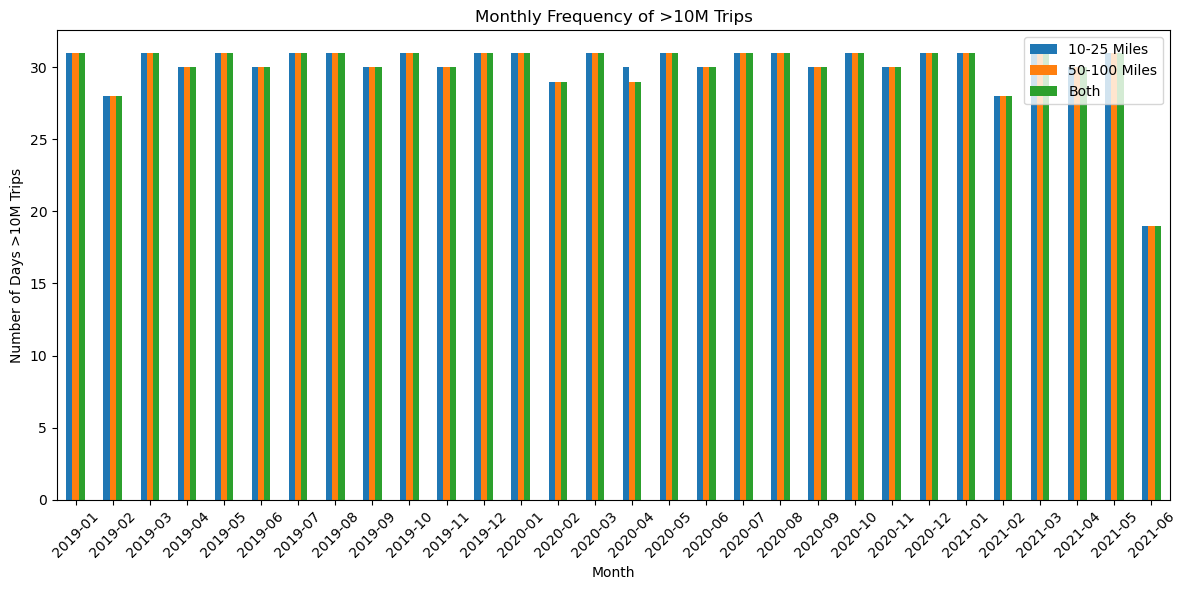

In [11]:
#  This chart shows a monthly breakdown of the number of days where 
# the number of trips exceeded 10 million in two distance categories: 
# 10–25 miles and 50–100 miles.

set_10_25_pd['Month'] = pd.to_datetime(set_10_25_pd['Date']).dt.to_period('M')
set_50_100_pd['Month'] = pd.to_datetime(set_50_100_pd['Date']).dt.to_period('M')
both_df['Month'] = pd.to_datetime(both_df['Date']).dt.to_period('M')

monthly_counts = pd.DataFrame({
    '10-25 Miles': set_10_25_pd['Month'].value_counts().sort_index(),
    '50-100 Miles': set_50_100_pd['Month'].value_counts().sort_index(),
    'Both': both_df['Month'].value_counts().sort_index()
})

monthly_counts.plot(kind='bar', figsize=(12, 6), title='Monthly Frequency of >10M Trips')
plt.ylabel('Number of Days >10M Trips')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 Your machine has 8 logical cores

 Simulating 10 processors using 10 partitions...


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time using 10 processors: 3.8687 seconds

 Simulating 20 processors using 20 partitions...


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time using 20 processors: 3.5132 seconds

 Running baseline (Pandas, sequential)...
 Sequential time: 2.2375 seconds


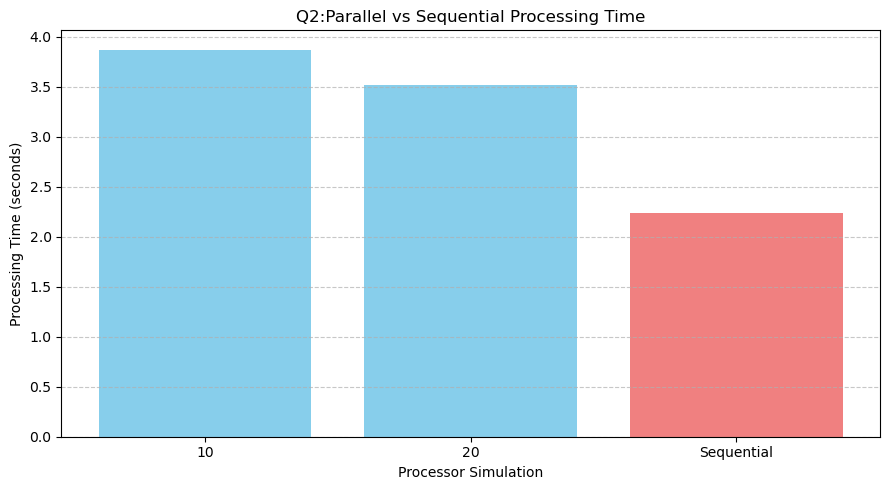

In [12]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import time
from dask.distributed import Client, LocalCluster
import os

# Load data
df1_pandas = pd.read_csv("trips_by_distance.csv.csv", low_memory=False)

# Check your machine
physical_cores = os.cpu_count()
print(f" Your machine has {physical_cores} logical cores")

# Test configurations simulating 10 and 20 processors (via partition count)
test_configs = {
    10: 10,
    20: 20,
}

processor_times = {}
results = {}

# Run for each simulated processor config
for label, partitions in test_configs.items():
    print(f"\n Simulating {label} processors using {partitions} partitions...")

    cluster = LocalCluster(n_workers=physical_cores, threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    ddf = dd.from_pandas(df1_pandas, npartitions=partitions)
    ddf['Date'] = dd.to_datetime(ddf['Date'], errors='coerce')

    # Filter for 'National' level and >10M trip values (real task!)
    ddf_filtered = ddf[ddf['Level'] == 'National']
    ddf_filtered = ddf_filtered[['Date', 'Number of Trips 10-25', 'Number of Trips 50-100']]
    filtered_result = ddf_filtered[
        (ddf_filtered['Number of Trips 10-25'] > 10_000_000) |
        (ddf_filtered['Number of Trips 50-100'] > 10_000_000)
    ].compute()

    end = time.time()
    processor_times[label] = end - start
    results[label] = filtered_result

    print(f" Time using {label} processors: {end - start:.4f} seconds")

    client.close()
    cluster.close()

# Sequential processing (baseline)
print("\n Running baseline (Pandas, sequential)...")
start_serial = time.time()

df1_pandas['Date'] = pd.to_datetime(df1_pandas['Date'], errors='coerce')
df1_clean = df1_pandas[df1_pandas['Level'] == 'National']
df1_clean = df1_clean[['Date', 'Number of Trips 10-25', 'Number of Trips 50-100']]
df1_filtered_seq = df1_clean[
    (df1_clean['Number of Trips 10-25'] > 10_000_000) |
    (df1_clean['Number of Trips 50-100'] > 10_000_000)
]

end_serial = time.time()
sequential_time = end_serial - start_serial
print(f" Sequential time: {sequential_time:.4f} seconds")

# Add to comparison dict
processor_times['Sequential'] = sequential_time

# Plotting
# Fix: Use numeric x-positions instead of string labels
labels = list(processor_times.keys())
times = list(processor_times.values())
x_pos = list(range(len(labels)))

plt.figure(figsize=(9, 5))
plt.bar(x_pos, times, color=['lightcoral' if l == 'Sequential' else 'skyblue' for l in labels])
plt.xticks(x_pos, labels)  # Assign string labels to x-ticks
plt.xlabel("Processor Simulation")
plt.ylabel("Processing Time (seconds)")
plt.title("Q2:Parallel vs Sequential Processing Time")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [13]:
###Random test code without using simulated parallel processing

import pandas as pd
import dask.dataframe as dd
import time
from dask.distributed import Client, LocalCluster

# Load the dataset once using Pandas for Dask conversion
df1_pandas = pd.read_csv("trips_by_distance.csv.csv", low_memory=False)

# Track performance time
n_processors = [4, 8]
processor_times = {}

for processor in n_processors:
    print(f"\n Running with {processor} workers")

    # Start Dask cluster
    cluster = LocalCluster(n_workers=processor, threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    # Convert to Dask DataFrame
    ddf = dd.from_pandas(df1_pandas, npartitions=processor)

    # General operations (no filtering)
    ddf['Date'] = dd.to_datetime(ddf['Date'], errors='coerce')
    result = ddf.describe().compute()

    end = time.time()
    processor_times[processor] = end - start

    print(f" Time with {processor} processors: {end - start:.4f} seconds")

    client.close()
    cluster.close()

# Summary
print("\n General Processing Time (No Filtering):")
for p, t in processor_times.items():
    print(f"{p} processors: {t:.4f} seconds")



 Running with 4 workers


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time with 4 processors: 5.0524 seconds

 Running with 8 workers


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time with 8 processors: 6.1752 seconds

 General Processing Time (No Filtering):
4 processors: 5.0524 seconds
8 processors: 6.1752 seconds


Model Evaluation Metrics:
R-squared: 0.9795
Mean Squared Error: 1479955330976.83
Mean Absolute Error: 1081294.18
Intercept: 111296900.31
Coefficients: [[1.76618129]]


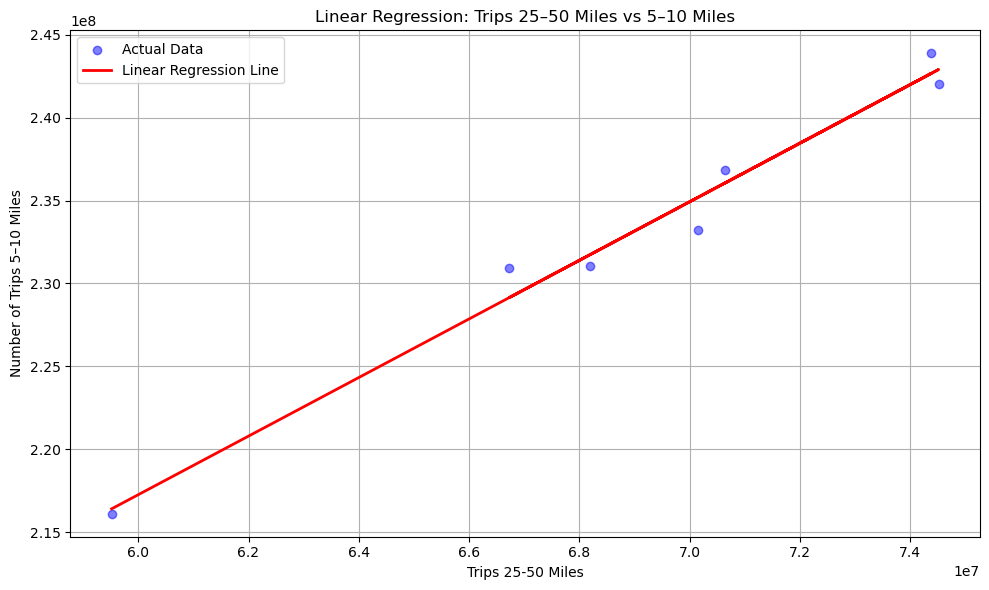

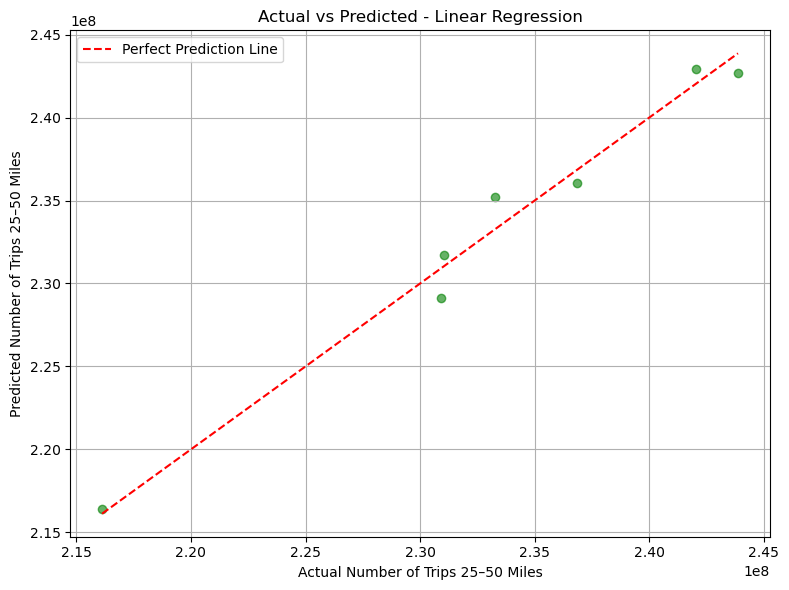

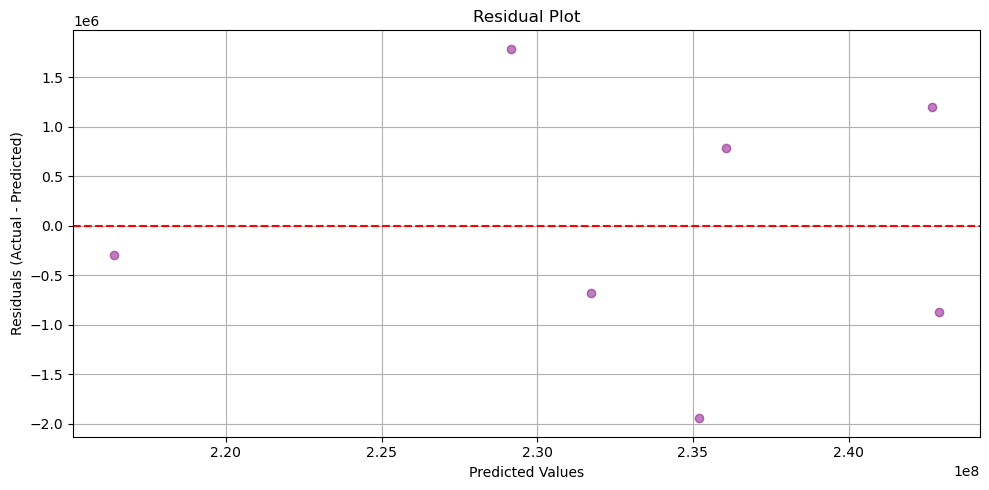

In [14]:
##Question 4  - Linear Regression Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load datasets
df1 = pd.read_csv("trips_by_distance.csv.csv", low_memory=False)
df2 = pd.read_csv("trips_full_data__2_.csv", low_memory=False)

# Convert Date columns to datetime
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

# Filter only National level data
national_only = df1[df1['Level'] == "National"].copy()
national_only['Date'] = pd.to_datetime(national_only['Date'], errors='coerce')

# Get overlapping date range from df2
start_date = df2['Date'].min()
end_date = df2['Date'].max()

# Filter both datasets for the same date range
filtered_df1 = national_only[national_only['Date'].between(start_date, end_date)]
filtered_df2 = df2[df2['Date'].between(start_date, end_date)]

# Reset index for alignment
filtered_df1 = filtered_df1.sort_values("Date").reset_index(drop=True)
filtered_df2 = filtered_df2.sort_values("Date").reset_index(drop=True)

# Prepare the model input
X = filtered_df2[["Trips 25-50 Miles"]].copy()
y = filtered_df1[["Number of Trips 5-10"]].copy()

# Drop missing values (if any)
model_data = pd.concat([X, y], axis=1).dropna()
X = model_data[["Trips 25-50 Miles"]]
y = model_data[["Number of Trips 5-10"]]

# Build Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

# Print model performance
print("Model Evaluation Metrics:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Intercept: {model.intercept_[0]:.2f}")
print(f"Coefficients: {model.coef_}")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')
plt.xlabel("Trips 25-50 Miles")
plt.ylabel("Number of Trips 5–10 Miles")
plt.title("Linear Regression: Trips 25–50 Miles vs 5–10 Miles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#  Plot: Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='green', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel("Actual Number of Trips 25–50 Miles")
plt.ylabel("Predicted Number of Trips 25–50 Miles")
plt.title("Actual vs Predicted - Linear Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Residual plot
residuals = y.values.flatten() - y_pred.flatten()
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, color='purple', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()






⚙️ Parallel Simulation: 10 processors, 10 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 R²: 0.9795, Time: 7.8172s

⚙️ Parallel Simulation: 20 processors, 20 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 R²: 0.9795, Time: 6.1178s

 Serial (Pandas) Version
 R²: 0.9795, Time: 5.2308s


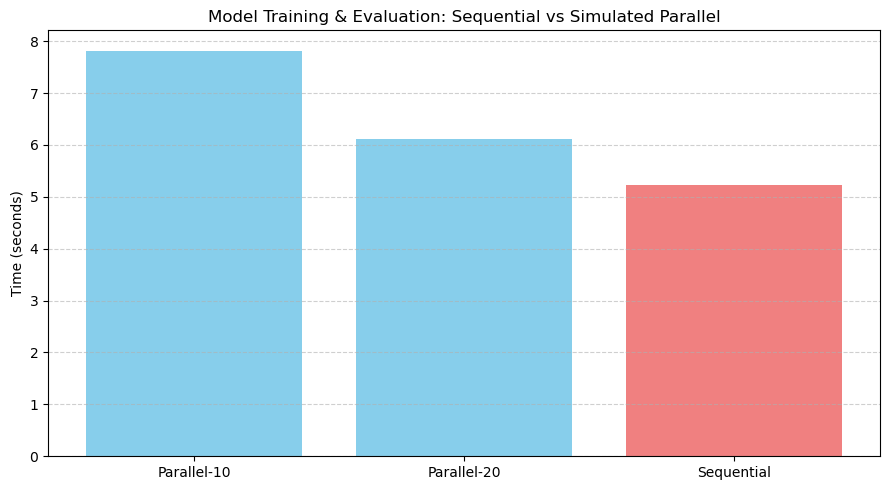

In [1]:
import pandas as pd
import numpy as np
import time
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# File paths
file1 = "trips_by_distance.csv.csv"
file2 = "trips_full_data__2_.csv"

# For storing results
model_times = {}

# Simulation configs
configs = {
    10: 10,   # simulate 10 processors
    20: 20    # simulate 20 processors
}

# Load df2 as pandas (since it's smaller and less filtered)
df2_pandas = pd.read_csv(file2, low_memory=False)
df2_pandas['Date'] = pd.to_datetime(df2_pandas['Date'], errors='coerce')

# Dates
start_date = df2_pandas['Date'].min()
end_date = df2_pandas['Date'].max()

for label, nparts in configs.items():
    print(f"\n Parallel Simulation: {label} processors, {nparts} partitions")

    # Setup Dask cluster
    cluster = LocalCluster(n_workers=8, threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    # Load df1 via Dask
    ddf = dd.read_csv(file1,assume_missing=True,dtype=str,  # Avoids dtype inference bugs
    blocksize="64MB"  # Smaller chunks, avoids RAM overload
)

    ddf['Date'] = dd.to_datetime(ddf['Date'], errors='coerce')
    ddf = ddf[ddf['Level'] == 'National']
    ddf = ddf[ddf['Date'].between(start_date, end_date)]
    ddf = ddf[['Date', 'Number of Trips 5-10']]

    df1_filtered = ddf.compute()

    # Preprocess df2
    df2_filtered = df2_pandas[df2_pandas['Date'].between(start_date, end_date)][['Date', 'Trips 25-50 Miles']]

    # Align & merge
    merged = pd.merge(df1_filtered, df2_filtered, on='Date', how='inner').dropna()
    X = merged[['Trips 25-50 Miles']]
    y = merged[['Number of Trips 5-10']]

    # Model training
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Evaluate
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    end = time.time()
    model_times[f"Parallel-{label}"] = end - start

    print(f" R²: {r2:.4f}, Time: {end - start:.4f}s")

    client.close()
    cluster.close()

# === Serial version ===
print("\n Serial (Pandas) Version")

start_serial = time.time()

# Load with Pandas
df1 = pd.read_csv(file1, low_memory=False)
df2 = pd.read_csv(file2, low_memory=False)

# Clean & filter
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')
df2['Date'] = pd.to_datetime(df2['Date'], errors='coerce')

df1 = df1[df1['Level'] == "National"]
df1 = df1[df1['Date'].between(start_date, end_date)]
df2 = df2[df2['Date'].between(start_date, end_date)]

# Merge & train
merged = pd.merge(df1[['Date', 'Number of Trips 5-10']],
                  df2[['Date', 'Trips 25-50 Miles']],
                  on='Date').dropna()

X = merged[['Trips 25-50 Miles']]
y = merged[['Number of Trips 5-10']]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

end_serial = time.time()
model_times['Sequential'] = end_serial - start_serial

print(f" R²: {r2:.4f}, Time: {end_serial - start_serial:.4f}s")

# === Plot Comparison ===
import matplotlib.pyplot as plt

labels = list(model_times.keys())
times = list(model_times.values())
x_pos = list(range(len(labels)))

plt.figure(figsize=(9, 5))
plt.bar(x_pos, times, color=['skyblue' if "Parallel" in l else 'lightcoral' for l in labels])
plt.xticks(x_pos, labels)
plt.ylabel("Time (seconds)")
plt.title("Model Training & Evaluation: Sequential vs Simulated Parallel")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Input features and target
X = model_data[["Trips 25-50 Miles"]]
y = model_data["Number of Trips 5-10"]  # Use Series, not DataFrame for y in CV

# Set up the model and 5-fold CV
model = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
y_pred_cv = cross_val_predict(model, X, y, cv=cv)

# Cross-validated evaluation metrics
r2_cv = r2_score(y, y_pred_cv)
mse_cv = mean_squared_error(y, y_pred_cv)
mae_cv = mean_absolute_error(y, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)

# Print results
print("Cross-Validation Evaluation Metrics (5-Fold):")
print(f"R-squared: {r2_cv:.4f}")
print(f"Mean Squared Error: {mse_cv:,.2f}")
print(f"Root Mean Squared Error: {rmse_cv:,.2f}")
print(f"Mean Absolute Error: {mae_cv:,.2f}")


Cross-Validation Evaluation Metrics (5-Fold):
R-squared: 0.9493
Mean Squared Error: 3,666,366,793,430.08
Root Mean Squared Error: 1,914,775.91
Mean Absolute Error: 1,836,744.83


 Your machine has 8 logical cores

 Simulating 10 processors with 8 actual workers and 32 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time simulating 10 processors: 10.1470 seconds
Serial (Pandas) processing time: 0.7987 seconds

 Simulating 20 processors with 8 actual workers and 20 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Time simulating 20 processors: 8.2024 seconds
Serial (Pandas) processing time: 0.7678 seconds

 Processing Time Comparison:
Simulated 10 processors: 10.1470 seconds
Simulated 20 processors: 8.2024 seconds


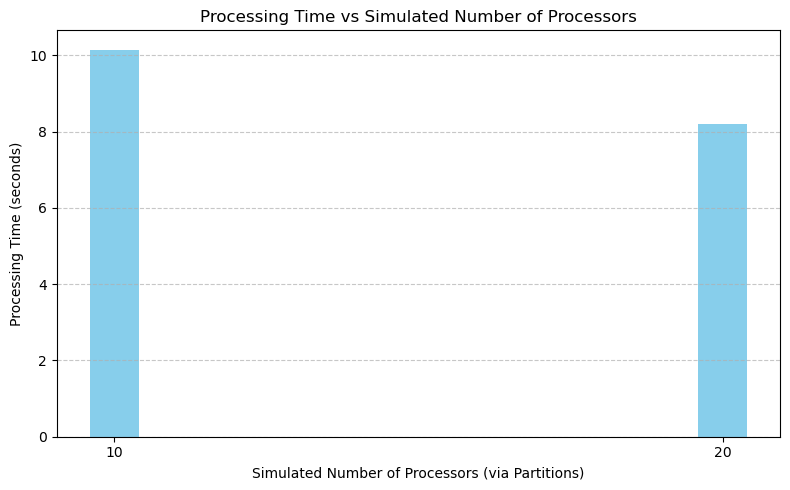

In [17]:
import pandas as pd
import dask.dataframe as dd
import time
from dask.distributed import Client, LocalCluster
import os

# Load CSV via Pandas
df1_pandas = pd.read_csv("trips_by_distance.csv.csv", low_memory=False)

# CPU info
physical_cores = os.cpu_count()  # should be 8
print(f" Your machine has {physical_cores} logical cores")

# Worker configs: Fixed workers, varying partitions (simulating more "parallelism")
test_configs = {
    10: 32,  # 10 partitions
    20: 20,  # 20 partitions
}

processor_times = {}

for label, partitions in test_configs.items():
    print(f"\n Simulating {label} processors with {physical_cores} actual workers and {partitions} partitions")

    # Set cluster with 8 actual workers (your CPU limit)
    cluster = LocalCluster(n_workers=physical_cores, threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    # Dask DataFrame with simulated partition count
    ddf = dd.from_pandas(df1_pandas, npartitions=partitions)

    # Some meaningful operation
    ddf['Date'] = dd.to_datetime(ddf['Date'], errors='coerce')
    result = ddf.describe().compute()

    end = time.time()
    processor_times[label] = end - start

    print(f" Time simulating {label} processors: {end - start:.4f} seconds")

    client.close()
    cluster.close()
    start_serial = time.time()
    operate = df1_pandas.describe()
    end_serial = time.time()
    print(f"Serial (Pandas) processing time: {end_serial - start_serial:.4f} seconds")


# Summary
print("\n Processing Time Comparison:")
for simulated, runtime in processor_times.items():
    print(f"Simulated {simulated} processors: {runtime:.4f} seconds")
    
labels = list(processor_times.keys())
times = list(processor_times.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color='skyblue')
plt.xlabel("Simulated Number of Processors (via Partitions)")
plt.ylabel("Processing Time (seconds)")
plt.title("Processing Time vs Simulated Number of Processors")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 Your machine has 8 logical cores

 Running with 10 processors and 10 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


Trial 1...
 Time: 3.0249 sec
Trial 2...
 Time: 1.0505 sec
Trial 3...
 Time: 0.9758 sec
 Avg Time with 10 processors: 1.6837 sec

 Running with 20 processors and 20 partitions


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


Trial 1...
 Time: 2.2741 sec
Trial 2...
 Time: 1.0642 sec
Trial 3...
 Time: 0.9493 sec
 Avg Time with 20 processors: 1.4292 sec

 Running sequential processing with Pandas...
Trial 1...
 Time: 0.1268 sec
Trial 2...
 Time: 0.1252 sec
Trial 3...
 Time: 0.1054 sec
 Avg Sequential Time: 0.1191 sec


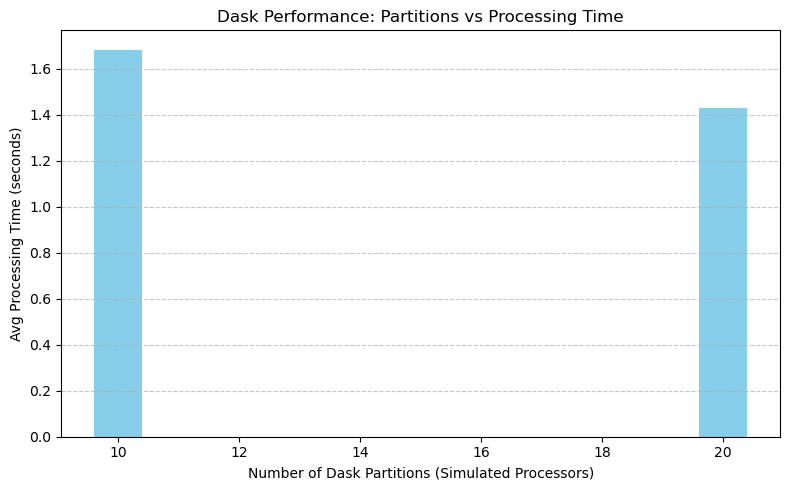

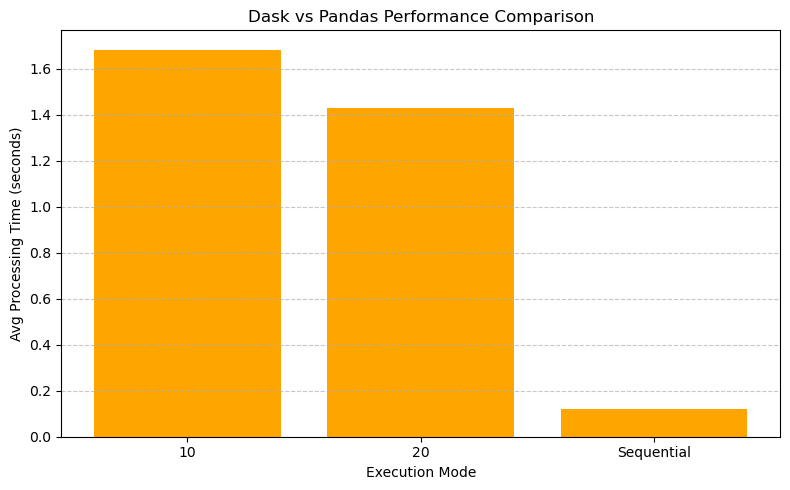

In [18]:
import pandas as pd
import dask.dataframe as dd
import time
from dask.distributed import Client, LocalCluster
import os
import matplotlib.pyplot as plt
import numpy as np

# Load CSV with Pandas
df = pd.read_csv("trips_by_distance.csv.csv", low_memory=False)

# Use only numeric columns for performance test
df_numeric = df.select_dtypes(include='number')

# CPU info
physical_cores = os.cpu_count()
print(f" Your machine has {physical_cores} logical cores")

# Simulate processor performance by changing number of partitions
configs = {
    10: 10,
    20: 20,
}

processor_times = {}

for processors, partitions in configs.items():
    print(f"\n Running with {processors} processors and {partitions} partitions")

    cluster = LocalCluster(n_workers=physical_cores, threads_per_worker=1)
    client = Client(cluster)

    times = []
    for trial in range(3):
        print(f"Trial {trial + 1}...")

        start = time.time()

        # Create Dask DataFrame
        ddf = dd.from_pandas(df_numeric, npartitions=partitions)

        # Lightweight compute
        result = ddf.mean().compute()

        end = time.time()
        elapsed = end - start
        times.append(elapsed)
        print(f" Time: {elapsed:.4f} sec")

    avg_time = np.mean(times)
    processor_times[processors] = avg_time
    print(f" Avg Time with {processors} processors: {avg_time:.4f} sec")

    client.close()
    cluster.close()
    # Sequential processing with Pandas (baseline)
print("\n Running sequential processing with Pandas...")

times_seq = []
for trial in range(3):
    print(f"Trial {trial + 1}...")
    start = time.time()

    result_seq = df_numeric.mean()  # Pandas computes eagerly

    end = time.time()
    elapsed = end - start
    times_seq.append(elapsed)
    print(f" Time: {elapsed:.4f} sec")

avg_seq_time = np.mean(times_seq)
processor_times["Sequential"] = avg_seq_time
print(f" Avg Sequential Time: {avg_seq_time:.4f} sec")


# First Plot: Dask Performance Only (Exclude Sequential)
dask_only = {k: v for k, v in processor_times.items() if k != "Sequential"}

plt.figure(figsize=(8, 5))
plt.bar(list(dask_only.keys()), list(dask_only.values()), color='skyblue')
plt.xlabel("Number of Dask Partitions (Simulated Processors)")
plt.ylabel("Avg Processing Time (seconds)")
plt.title("Dask Performance: Partitions vs Processing Time")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Second Plot: Dask vs Pandas Sequential
plt.figure(figsize=(8, 5))

# Combine all configurations including Sequential
all_keys = list(dask_only.keys()) + ["Sequential"]
all_values = [processor_times[k] for k in all_keys]

# Map labels to numeric x-axis positions
x_pos = np.arange(len(all_keys))

plt.bar(x_pos, all_values, color='orange')
plt.xticks(x_pos, all_keys)  # Set string labels on x-axis
plt.xlabel("Execution Mode")
plt.ylabel("Avg Processing Time (seconds)")
plt.title("Dask vs Pandas Performance Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd

#  1. Filter only National-level data from the big dataset
national_only = df1[df1['Level'] == "National"]

#  2. Drop location-related columns (they're all NaN for National)
national_only = national_only.drop(
    columns=['State FIPS', 'State Postal Code', 'County FIPS', 'County Name'],
    errors='ignore'
)

#  3. Filter df1 by the date range in df2
start_date = df2['Date'].min().compute() if isinstance(df2, dd.DataFrame) else df2['Date'].min()
end_date = df2['Date'].max().compute() if isinstance(df2, dd.DataFrame) else df2['Date'].max()
national_only = national_only[national_only["Date"].between(start_date, end_date)]

#  4. Clean df2 by dropping unnecessary columns
df2 = df2.drop(
    columns=["Month of Date", "Week of Date", "Year of Date", "Level", "Date", "Trips", "Week Ending Date"],
    errors='ignore')

#  5. Calculate mean number of trips per distance
trip_means = df2.select_dtypes(include='number').mean().compute() if isinstance(df2, dd.DataFrame) else df2.select_dtypes(include='number').mean()

#  6. Plot Distance vs Average Trips
plt.figure(figsize=(12, 6))
trip_means.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title(' Average Number of Trips by Distance (National Level)')
plt.xlabel('Distance Categories')
plt.ylabel('Average Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



C:\Users\dell\AppData\Local\Temp\ipykernel_15212\3589740930.py:34: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from current font.
  plt.tight_layout()
C:\Users\dell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(



 Running Parallel-10 with 10 partitions...
 Parallel-10 completed in 2.0504 seconds

 Running Parallel-20 with 20 partitions...


C:\Users\dell\anaconda3\Lib\site-packages\distributed\dashboard\core.py:20: UserWarning: 
Dask needs bokeh >= 2.4.2, < 3 for the dashboard.
You have bokeh==3.2.1.
Continuing without the dashboard.
  warnings.warn(


 Parallel-20 completed in 1.5041 seconds

 Running Serial (Pandas) Version...
 Serial version completed in 5.7637 seconds


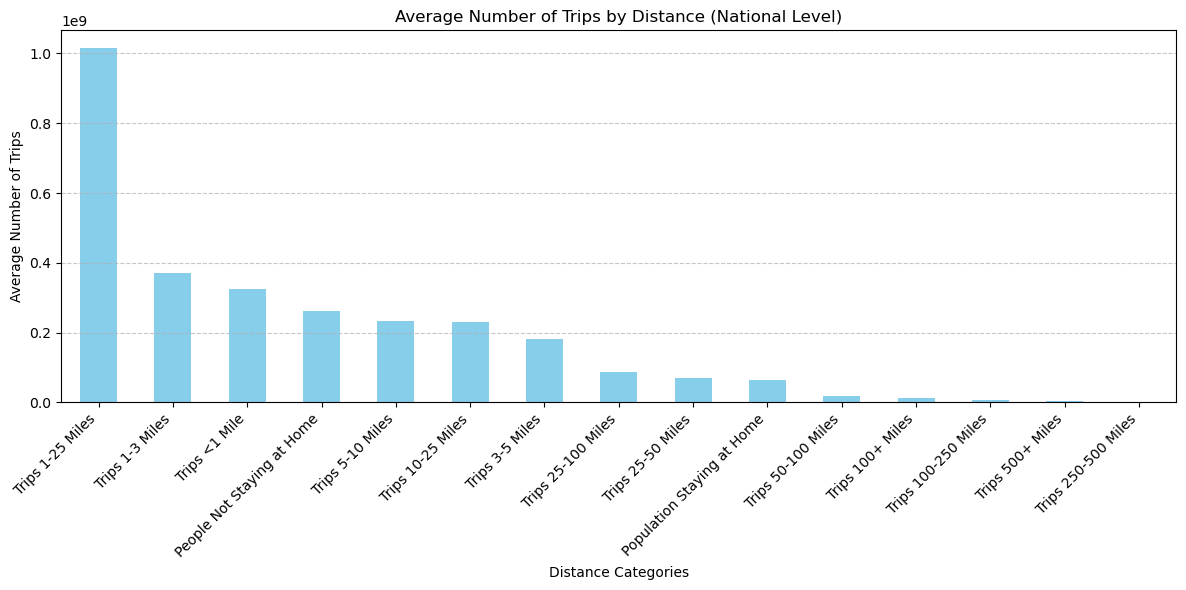

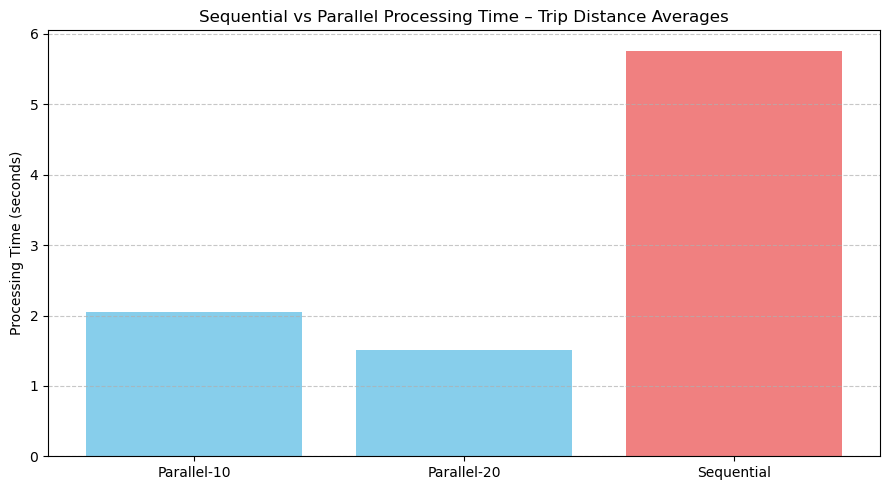


 Summary:
Parallel-10: 2.0504 seconds
Parallel-20: 1.5041 seconds
Sequential: 5.7637 seconds


In [20]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import time
from dask.distributed import Client, LocalCluster
import os

# File paths
file1 = "trips_by_distance.csv.csv"
file2 = "trips_full_data__2_.csv"

# Load df2 (smaller one) as Pandas always
df2_pandas = pd.read_csv(file2, low_memory=False)
df2_pandas['Date'] = pd.to_datetime(df2_pandas['Date'], errors='coerce')

# Determine common date range
start_date = df2_pandas['Date'].min()
end_date = df2_pandas['Date'].max()

# Timing results
viz_times = {}

# Test with parallel configs
test_configs = {
    "Parallel-10": 10,
    "Parallel-20": 20
}

for label, nparts in test_configs.items():
    print(f"\n Running {label} with {nparts} partitions...")

    cluster = LocalCluster(n_workers=os.cpu_count(), threads_per_worker=1)
    client = Client(cluster)

    start = time.time()

    # Load df1 in Dask
    ddf1 = dd.read_csv(file1, assume_missing=True, dtype=str)
    ddf1['Date'] = dd.to_datetime(ddf1['Date'], errors='coerce')

    # Filter National-level & date range
    ddf1 = ddf1[ddf1['Level'] == "National"]
    ddf1 = ddf1[ddf1["Date"].between(start_date, end_date)]
    ddf1 = ddf1.drop(columns=['State FIPS', 'State Postal Code', 'County FIPS', 'County Name'], errors='ignore')

    # df2 cleanup
    df2_clean = df2_pandas.drop(
        columns=["Month of Date", "Week of Date", "Year of Date", "Level", "Date", "Trips", "Week Ending Date"],
        errors='ignore'
    )

    # Calculate means using Dask
    ddf2 = dd.from_pandas(df2_clean, npartitions=nparts)
    trip_means = ddf2.select_dtypes(include='number').mean().compute()

    end = time.time()
    viz_times[label] = end - start

    print(f" {label} completed in {end - start:.4f} seconds")

    client.close()
    cluster.close()

# === Serial (Pandas) Version ===
print("\n Running Serial (Pandas) Version...")
start_serial = time.time()

# Load as Pandas
df1 = pd.read_csv(file1, low_memory=False)
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')

# Filter
df1 = df1[df1['Level'] == "National"]
df1 = df1[df1["Date"].between(start_date, end_date)]
df1 = df1.drop(columns=['State FIPS', 'State Postal Code', 'County FIPS', 'County Name'], errors='ignore')

# Clean df2 again
df2_clean = df2_pandas.drop(
    columns=["Month of Date", "Week of Date", "Year of Date", "Level", "Date", "Trips", "Week Ending Date"],
    errors='ignore'
)

trip_means_serial = df2_clean.select_dtypes(include='number').mean()

end_serial = time.time()
viz_times['Sequential'] = end_serial - start_serial
print(f" Serial version completed in {end_serial - start_serial:.4f} seconds")

# === Plot bar chart for one version (trip_means_serial or latest parallel) ===
plt.figure(figsize=(12, 6))
trip_means_serial.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Number of Trips by Distance (National Level)')
plt.xlabel('Distance Categories')
plt.ylabel('Average Number of Trips')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# === Compare Timing ===
labels = list(viz_times.keys())
times = list(viz_times.values())
x_pos = list(range(len(labels)))

plt.figure(figsize=(9, 5))
plt.bar(x_pos, times, color=['lightcoral' if 'Sequential' in l else 'skyblue' for l in labels])
plt.xticks(x_pos, labels)
plt.ylabel("Processing Time (seconds)")
plt.title("Sequential vs Parallel Processing Time – Trip Distance Averages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Summary
print("\n Summary:")
for label in labels:
    print(f"{label}: {viz_times[label]:.4f} seconds")
